# COM3029 Coursework 2 - Group 9

## Research of Model Serving Options

Should this be in the report instead?

## Web Service

The Flask web server script from `webserver.py` is shown below, and has been adapted to run in this notebook if necessary. Running the script manually is possible with the `waitress-serve --listen=localhost:5000 webserver:app` console command

In [1]:
# Model
from transformers import AutoTokenizer, BertForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("model")
model = BertForSequenceClassification.from_pretrained("model")

labels = ["admiration", "amusement", "anger", "annoyance", "curiosity", "disapproval", "gratitude", "joy", "love", "optimism", "remorse", "sadness", "surprise", "neutral"]

def predict_label(prompt):
    inputs = tokenizer(prompt, return_tensors="pt")

    outputs = model(**inputs)
    
    label_index = torch.argmax(outputs.logits, dim=1).item()

    return labels[label_index]
    
# Logging
import json
import logging
from logging.config import dictConfig
from datetime import datetime

dictConfig({
    "version": 1,
    "formatters": {
        "default": {
            "format": "%(message)s",
        }
    },
    "handlers": {
        "file": {
            "class": "logging.FileHandler",
            "filename": "predictions.txt",
            "formatter": "default",
        },
    },
    "root": {"level": "INFO", "handlers": ["file"]},
})

# Prevent regular app messages getting logged.
logging.getLogger("werkzeug").disabled = True

# Use Python's structured logging to make it machine-parseable.
class LogMsg(object):
    def __init__(self, text, prediction):
        self.text = text
        self.prediction = prediction
        self.time = datetime.now().strftime('%Y-%m-%d %H:%M:%S:%f')

    def __str__(self):
        return json.dumps({'time': self.time, 'text': self.text, 'prediction': self.prediction})
    
class LogMsgInputFormat400Error(object):
    def __init__(self):
        self.time = datetime.now().strftime('%Y-%m-%d %H:%M:%S:%f')

    def __str__(self):
        return json.dumps({'time': self.time, 'error': "The message must be JSON in the form json={'comment': string_to_predict}."})

# Webserver
from flask import Flask, request

app = Flask(__name__)

@app.route("/", methods=['GET', 'POST'])
def get_prediction():
    if request.method == 'GET':
        return "To receive predictions, send a POST request in the form json={'comment': string_to_predict}."
    else:
        if ((type(request.json) != dict) or (list(request.json.keys()) != ['comment']) or (type(request.json['comment']) != str) or (len(request.json["comment"])==0)):
            app.logger.info(LogMsgInputFormat400Error())
            return json.dumps({"success": False, "error":"The message must be JSON in the form json={'comment': string_to_predict}."}), 400
        comment_text = request.json['comment']
        prediction = predict_label(comment_text)
        app.logger.info(LogMsg(comment_text, prediction))
        return json.dumps({"success": True, "prediction": prediction})


########################################################################
##       Notebook only. Remove this to run as a normal .py script.    ##
########################################################################

from waitress import serve
from IPython.lib import backgroundjobs

def serve_webserver():
    serve(app, host='127.0.0.1', port=5000)

server = backgroundjobs.BackgroundJobManager()
server.new(serve_webserver)

<BackgroundJob #0: <function serve_webserver at 0x0000028EA417AA60>>

And a quick test to make sure it is running and receiving requests properly:

In [2]:
import requests

print(requests.get('http://127.0.0.1:5000/').text)

def send_prediction_request(string_to_predict):
    return requests.post('http://127.0.0.1:5000/', json={'comment': string_to_predict}).text

print(send_prediction_request('test comment 1'))
print(send_prediction_request('test comment 2'))

To receive predictions, send a POST request in the form json={'comment': string_to_predict}.
{"success": true, "prediction": "neutral"}
{"success": true, "prediction": "neutral"}


## Endpoint Testing

### Unit Tests

The command below runs the unit tests contained within the `test.py` file. This requires that the webserver is running.

In [3]:
!python -m unittest 

........
----------------------------------------------------------------------
Ran 8 tests in 0.263s

OK


### Model Accuracy

This test uses 50 comments from the GoEmotions testing dataset to estimate the accuracy of the model. The transformer model used in our web service should achieve an accuracy of around 60-65%. This is not intended to be a thorough test, but simply to establish that the deployed model is performing at the expected level.

In [4]:
import random
import datasets
from tqdm import tqdm

dataset = datasets.load_dataset("go_emotions")

# Maps all unchosen labels to their most similar counterpart.
label_mappings = [
    'admiration', 'amusement', 'anger', 'annoyance', 'admiration', 'optimism', 'curiosity',
    'curiosity', 'optimism', 'sadness', 'disapproval', 'annoyance', 'sadness', 'joy',
    'sadness', 'gratitude', 'sadness', 'joy', 'love', 'sadness', 'optimism',
    'admiration', 'admiration', 'gratitude', 'remorse', 'sadness', 'surprise', 'neutral'
]

count = 50
correct = 0
for i in tqdm(range(count)):
    choice = random.choice(dataset['test'])
    prediction = requests.post('http://127.0.0.1:5000/', json={'comment': choice['text']}).json()['prediction']
    
    if prediction in [label_mappings[x] for x in choice['labels']]:
        correct += 1
        
print("Correct: " + str(correct) + "    Incorrect: " + str(count - correct))

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:08<00:00,  5.60it/s]

Correct: 14    Incorrect: 36


## Service Performance & Stress Testing

The stress testing script is run from the command line once the web service is running, as shown here:

No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (C:/Users/ryans/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)
No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (C:/Users/ryans/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                    

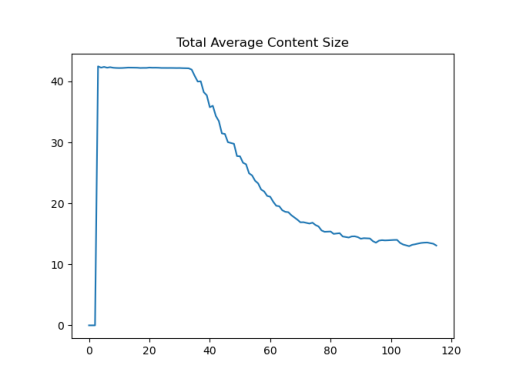

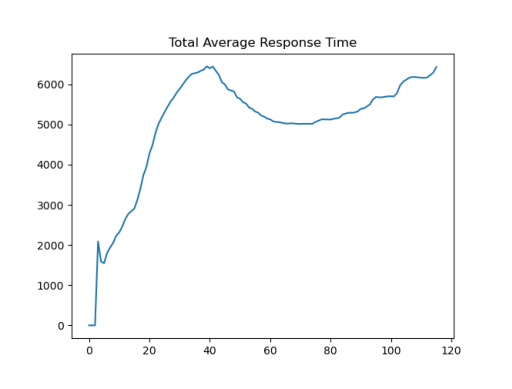

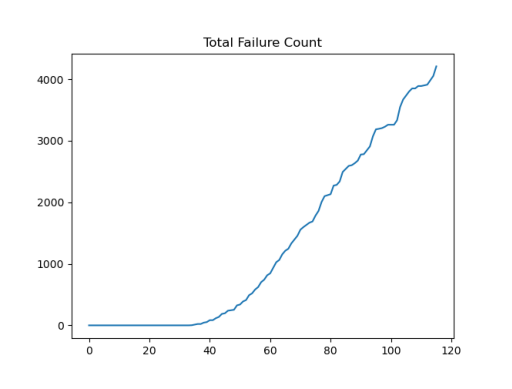

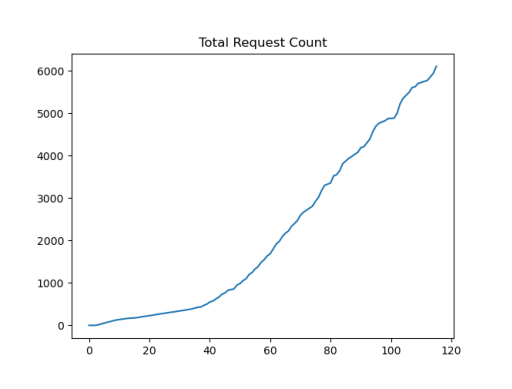

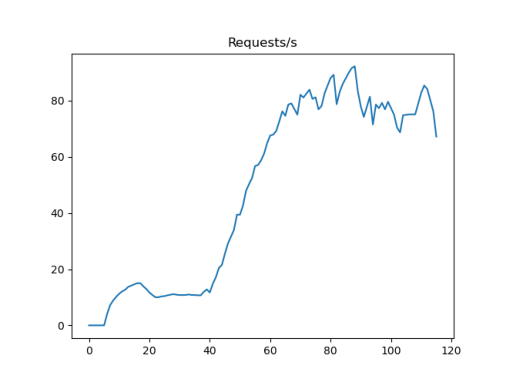

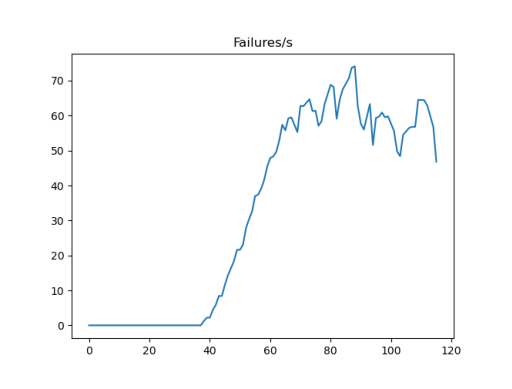

  Method Name                                              Error  Occurrences
0   POST    /  ConnectionRefusedError(10061, '[WinError 10061...         4603


<Figure size 640x480 with 0 Axes>

In [5]:
!python stress_test.py -u 1000 -r 10 -l 120

graph_names = ["Total Average Content Size.png", "Total Average Response Time.png", 
               "Total Failure Count.png", "Total Request Count.png", "Requests_per_s.png", 
               "Failures_per_s.png"]

import matplotlib.pyplot as plt
import matplotlib.image as pltim
import pandas as pd

for graph_name in graph_names:
    image = pltim.imread(graph_name)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    plt.clf()

failures = pd.read_csv('_failures.csv')
print(failures)


The contents of this file is shown below for reference:

```python
import gevent
from locust import HttpUser, task, events
from locust.env import Environment
from locust.stats import stats_printer, stats_history, StatsCSVFileWriter
from locust.log import setup_logging

from locustfile import StressTest

import matplotlib.pyplot as plt
import pandas as pd

from argparse import ArgumentParser

if __name__ == '__main__':
    parser = ArgumentParser()
    parser.add_argument("-u", "--user_count", dest="user_count", help="How many users to be created during a spawn", type=int, default=1)
    parser.add_argument("-r", "--spawn_rate", dest="spawn_rate", help="How many groups of users should be created every second", type=int, default=1)
    parser.add_argument("-l", "--length", dest="duration", help="How long the stress test should last for", type=int, default=30)

    stress_args = parser.parse_args()


    setup_logging("INFO", None)


    # setup Environment and Runner
    env = Environment(user_classes=[StressTest], events=events)
    runner = env.create_local_runner()

    # start a WebUI instance
    web_ui = env.create_web_ui("127.0.0.1", 8089)

    logging = StatsCSVFileWriter(environment=env, base_filepath='./', full_history=True, percentiles_to_report=[90.0])

    # execute init event handlers (only really needed if you have registered any)
    env.events.init.fire(environment=env, runner=runner, web_ui=web_ui)

    # start a greenlet that periodically outputs the current stats
    gevent.spawn(stats_printer(env.stats))

    gevent.spawn(logging)

    # start a greenlet that save current stats to history
    gevent.spawn(stats_history, env.runner)

    # start the test
    runner.start(user_count=stress_args.user_count, spawn_rate=stress_args.spawn_rate)

    # in duration seconds stop the runner
    gevent.spawn_later(stress_args.duration, lambda: runner.quit())

    # wait for the greenlets
    runner.greenlet.join()

    # stop the web server for good measures
    web_ui.stop()

    graph_stats = pd.read_csv('_stats_history.csv')
    graph_stats = graph_stats[graph_stats['Name'] == 'Aggregated']
    x_axis = graph_stats['Timestamp']
    x_axis = x_axis - x_axis.min()

    target_metrics = ['Requests/s','Failures/s','Total Request Count','Total Failure Count','Total Average Response Time']

    for metric in target_metrics:
        y_axis = graph_stats[metric].astype(float)

        plt.plot(list(x_axis.values), list(y_axis.values))
        plt.title(metric)
        save_name = metric.replace('/', '_per_')
        plt.savefig(f'{save_name}.png')
        plt.clf()
```

## Monitoring Capabilities

In order to monitor the user input and predictions of the webservice, the server uses Python's `logging` library to log to a file. For every prediction request made by each user, the time, input text, and predicted label is written as JSON to the `predictions.txt` log file, an example snippet of which is shown here:

```json
{"time": "2023-05-23 00:58:45:748136", "text": "literally I feel like crying", "prediction": "sadness"}
{"time": "2023-05-23 00:58:46:135930", "text": "i love this subreddit", "prediction": "love"}
```

JSON is used so that the log file can be parsed programatically and used by a different service, if if ever becomes necessary. This structured logging is implemented using a custom class to store all the necessary data. There is also a class to log error messages, for when the user sends invalid text. Both of these are shown below:

```python
class LogMsg(object):
    def __init__(self, text, prediction):
        self.text = text
        self.prediction = prediction
        self.time = datetime.now().strftime('%Y-%m-%d %H:%M:%S:%f')

    def __str__(self):
        return json.dumps({'time': self.time, 'text': self.text, 'prediction': self.prediction})
    
class LogMsgInputFormat400Error(object):
    def __init__(self):
        self.time = datetime.now().strftime('%Y-%m-%d %H:%M:%S:%f')

    def __str__(self):
        return json.dumps({'time': self.time, 'error': "The message must be JSON in the form json={'comment': string_to_predict}."})
```

Logging a regular request and an invalid request are then done like so:

```python
# Invalid request:
app.logger.info(LogMsgInputFormat400Error())

# Valid request:
app.logger.info(LogMsg(comment_text, prediction))
```

## CI/CD Pipeline

CI/CD for this web service is performed using the `ci-cd-script.sh` bash script, the contents of which is shown below. This script first calls the `build-and-save-model.py` python script, which will do all of the training for the new model and save it and the tokenizer config to the `./model` directory. Once that has finished, the web service is started in the background as normal, and then the unit tests are run. This ensures that the behaviour of the new model is still correct. Finally, the web service is killed and the new model is committed to the Git repository with a commit labelled for the current date and time.

```bash
#!/bin/bash

echo "--- Running CI/CD script ---"

# Build and save the model to the ./model directory.
echo "Training and saving model..."
python3 ./build-and-save-model.py

# Begin the webserver in the background.
echo "Starting webservice..."
waitress-serve --listen=localhost:5000 webserver:app &

# Allow time for the webserver to start up.
sleep 3

# Run unit tests to ensure the new model is functioning.
echo "Running unit tests..."
python3 -m unittest

# Kill the webserver.
echo "Exiting..."
kill %%

git_datetime=$(date +"%Y-%m-%d %T")

# Push the model changes to Git.
git add .
git commit -m "[CI/CD]: ${git_datetime}"
git push
```

An example output for a run of this script is shown here: